In [105]:
import os
import json
import numpy as np
import einops
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle

In [101]:
data_dir = "/large_experiments/3po/data/arctic/arctic/data/arctic_data/data"
save_dir = "/private/home/taoshaf/data/arctic/bboxes"
mocap_dir = os.path.join(data_dir, "mocap_npy")
img_dir = os.path.join(data_dir, "images")
seqs = [
    "/".join(seq.split(".npy")[0].split("_", 1))
    for seq in sorted(os.listdir(mocap_dir))
]

with open(
    "/large_experiments/3po/data/arctic/arctic/data/arctic_data/data/meta/misc.json"
) as f:
    meta_data = json.load(f)

In [112]:
",".join(seqs[:5])

's01/box_grab_01,s01/box_use_01,s01/box_use_02,s01/capsulemachine_grab_01,s01/capsulemachine_use_01'

In [ ]:
seq = seqs[0]
subject = seq.split("/")[0]

In [59]:
offset = meta_data[subject]["ioi_offset"]
cams_int = np.array(meta_data[subject]["intris_mat"])
cams_int = np.concatenate(
    [
        cams_int[:, 0, 0][:, None],
        cams_int[:, 1, 1][:, None],
        cams_int[:, 0, 2][:, None],
        cams_int[:, 1, 2][:, None],
    ],
    axis=-1,
)
cams_ext = np.array(meta_data[subject]["world2cam"])[:, :3]
cams_ext[:, :3, 3] *= 100

mocap_file = os.path.join(mocap_dir, f"{seq.replace('/', '_')}.npy")
mocap_data = np.load(mocap_file, allow_pickle=True)[()]
markers = mocap_data["subject"]["points"] / 10
markers_cam = (
    einops.einsum(cams_ext[:, :, :3], markers, "n i j, b k j->b n k i")
    + cams_ext[:, :, 3][None, :, None]
)

markers_2d = (markers_cam[:, :, :, :2] / markers_cam[:, :, :, [2]]) * cams_int[
    :, None, :2
] + cams_int[:, None, 2:]

cams = [f"{cam_idx}" for cam_idx in range(1, 9)]
img_sizes = np.array(meta_data[subject]["image_size"][1:])

In [89]:
bboxes = (
    np.concatenate(
        [
            markers_2d.min(axis=-2).clip([0, 0], img_sizes[None]),
            markers_2d.max(axis=-2).clip([0, 0], img_sizes[None]),
        ],
        axis=-1,
    )
    .round()
    .astype(int)
)
bbox_centers = (bboxes[..., :2] + bboxes[..., 2:]) / 2
bbox_scales = bboxes[..., 2:] - bboxes[..., :2]
bboxes = (
    np.concatenate(
        [
            (bbox_centers - 0.55 * bbox_scales).clip([0, 0], img_sizes[None]),
            (bbox_centers + 0.55 * bbox_scales).clip([0, 0], img_sizes[None]),
        ],
        axis=-1,
    )
    .round()
    .astype(int)
)

In [98]:
frame_idx = 100
img_idx = frame_idx + offset
cam_idx = 5
cam = cams[cam_idx]
bbox = bboxes[frame_idx, cam_idx]
img = cv2.imread(os.path.join(img_dir, seq, cam, f"{img_idx:05}.jpg"))[:, :, ::-1]

In [111]:
bbox_dir = os.path.join(save_dir, seq)
for cam_idx, cam in enumerate(cams):
    bbox_cam_dir = os.path.join(bbox_dir, cam)
    if not os.path.exists(bbox_cam_dir):
        os.makedirs(bbox_cam_dir)
    num_frames = bboxes.shape[0]
    for frame_idx in range(num_frames):
        img_idx = frame_idx + offset
        with open(os.path.join(bbox_cam_dir, f"{img_idx:05}.pkl"), "wb") as f:
            pickle.dump(bboxes[frame_idx, cam_idx], f)

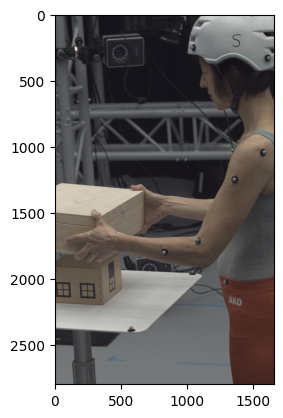

In [99]:
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2]])

### Launch Slurm

In [1]:
import os
import subprocess
import numpy as np
import random

In [2]:
data_dir = "/large_experiments/3po/data/arctic/arctic/data/arctic_data/data"
mocap_dir = os.path.join(data_dir, "mocap_npy")
seqs = [
    "/".join(seq.split(".npy")[0].split("_", 1))
    for seq in sorted(os.listdir(mocap_dir))
]

In [6]:
num_seqs = len(seqs)
num_jobs = min(len(seqs), 64)
num_seqs_per_job = num_seqs // num_jobs
seqs_for_jobs = [
    num_seqs_per_job + (job < (num_seqs - num_seqs_per_job * num_jobs))
    for job in range(num_jobs)
]
seq_offsets = np.cumsum([0] + seqs_for_jobs)

In [10]:
common_cmds = [
    "sbatch",
    "launch/submit_jobs.bash",
    "scripts/extract_bboxes.py",
]

for job in range(num_jobs):
    cmds = common_cmds + ["--seqs", ",".join(seqs[seq_offsets[job]:seq_offsets[job+1]])]
    print(" ".join([f"{job}"] + cmds))
    subprocess.run(cmds, cwd="..")

0 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/box_grab_01,s01/box_use_01,s01/box_use_02,s01/capsulemachine_grab_01,s01/capsulemachine_use_01
Submitted batch job 52844613
1 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/capsulemachine_use_02,s01/espressomachine_grab_01,s01/espressomachine_use_01,s01/espressomachine_use_02,s01/ketchup_grab_01


Submitted batch job 52844614
2 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/ketchup_use_01,s01/ketchup_use_02,s01/laptop_grab_01,s01/laptop_use_01,s01/laptop_use_02
Submitted batch job 52844615
3 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/laptop_use_03,s01/laptop_use_04,s01/microwave_grab_01,s01/microwave_use_01,s01/microwave_use_02
Submitted batch job 52844616
4 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/mixer_grab_01,s01/mixer_use_01,s01/mixer_use_02,s01/notebook_use_01,s01/notebook_use_02
Submitted batch job 52844617
5 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/phone_grab_01,s01/phone_use_01,s01/phone_use_02,s01/scissors_grab_01,s01/scissors_use_01
Submitted batch job 52844618
6 sbatch launch/submit_jobs.bash scripts/extract_bboxes.py --seqs s01/scissors_use_02,s01/waffleiron_grab_01,s01/waffleiron_use_01,s01/waffleiron_use_02,s02/box_grab_01
Submitted batch job 52844619
7 sbatch launch